In [27]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 

from PIL import Image

from ResNet import Bottleneck, ResNet, ResNet50

In [28]:
class Dataset():
    def __init__(self, list_image_path, list_txt, train: bool):
        # Initialize image paths and corresponding texts
        self.image_path = list_image_path
        # Tokenize text using CLIP's tokenizer
        self.label  = list_txt

        self.train = train

        self.transform_train = transforms.Compose([
            # transforms.RandomHorizontalFlip(),
            # transforms.RandomCrop(32, padding=4),
            transforms.Resize(size=[256,256]),
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
        ])

        self.transform_test = transforms.Compose([
            transforms.Resize(size=[256,256]),
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
        ])

    def __len__(self):
        return len(self.label)

    def __getitem__(self, idx):
        # Preprocess image using CLIP's preprocessing function
        if self.train:
            image = self.transform_train(Image.open(self.image_path[idx]))
        else:
            image = self.transform_test(Image.open(self.image_path[idx]))

        label = self.label[idx]
        return image, label

In [29]:
BATCH_SIZE = 8
LEARNING_RATE = 0.1
EPOCHS = 20

In [ ]:
# df = pd.read_csv('data/data.csv')
df = pd.read_csv('data_balanced/data.csv')


In [5]:
str_labels = list(set(df['label']))
dataloaders = {}

for x in ['train', 'test']:
    df_ = df[(df['tag']==x)]

    img_path = df_['image_path'].tolist()
    labels = df_['int_label'].tolist()

    print(f'length of {x} split: {len(labels)}')

    dataset = Dataset(img_path, labels, train=(x=='train'))
    dataloaders[x] = torch.utils.data.DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)

    print(f'Num of Batches in {x} dataloader: {len(dataloaders[x])}')

    # if x == 'train':
    #     train_dataset = Dataset(img_path, labels, train=True)
    #     trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=2)
    # else:
    #     test_dataset = Dataset(img_path, labels, train=True)
    #     testloader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=True, num_workers=2)
        


length of train split: 677
Num of Batches in train dataloader: 85
length of test split: 197
Num of Batches in test dataloader: 25


In [6]:
def imshow(inp, title=None):
    """Display image for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

8


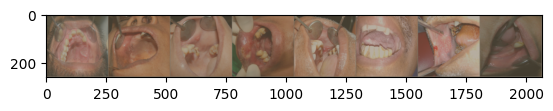

In [7]:
# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)
print(len(inputs))
imshow(out)

In [8]:
classes = list(set(dataset.label))
classes

[0, 1, 2, 3, 4, 5]

In [9]:
net = ResNet50(10).to('cuda')

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=LEARNING_RATE, momentum=0.9, weight_decay=0.0001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor = 0.1, patience=5)

In [10]:
for epoch in range(EPOCHS):
    losses = []
    running_loss = 0
    for i, inp in enumerate(dataloaders['train']):
        # print(i)
        inputs, labels = inp
        inputs, labels = inputs.to('cuda'), labels.to('cuda')
        optimizer.zero_grad()
    
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        losses.append(loss.item())

        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
        if i%(len(dataloaders['train'])-1) == 0 and i > 0:
            print(f'Loss [{epoch+1}, {i}](epoch, minibatch): ', round((running_loss / 100),ndigits=4))
            running_loss = 0.0

    avg_loss = sum(losses)/len(losses)
    scheduler.step(avg_loss)
            
print('Training Done')

Loss [1, 84](epoch, minibatch):  4.9439
Loss [2, 84](epoch, minibatch):  1.4435
Loss [3, 84](epoch, minibatch):  1.3679
Loss [4, 84](epoch, minibatch):  1.3227
Loss [5, 84](epoch, minibatch):  1.2915
Loss [6, 84](epoch, minibatch):  1.2799
Loss [7, 84](epoch, minibatch):  1.2775
Loss [8, 84](epoch, minibatch):  1.2667
Loss [9, 84](epoch, minibatch):  1.266
Loss [10, 84](epoch, minibatch):  1.2653
Loss [11, 84](epoch, minibatch):  1.2523
Loss [12, 84](epoch, minibatch):  1.2613
Loss [13, 84](epoch, minibatch):  1.2504
Loss [14, 84](epoch, minibatch):  1.2527
Loss [15, 84](epoch, minibatch):  1.244
Loss [16, 84](epoch, minibatch):  1.2443
Loss [17, 84](epoch, minibatch):  1.2427
Loss [18, 84](epoch, minibatch):  1.2311
Loss [19, 84](epoch, minibatch):  1.2387
Loss [20, 84](epoch, minibatch):  1.2391
Training Done


In [10]:
# torch.save(net.state_dict(), 'model_weights.pth')

In [19]:
y_true = []
y_pred = []

correct = 0
total = 0
with torch.no_grad():
    for i, data in enumerate(dataloaders['test']):
        images, labels = data
        images, labels = images.to('cuda'), labels.to('cuda')
        outputs = net(images)
        
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
        y_true += [np.array(i.cpu()) for i in labels]
        y_pred += [np.array(i.cpu()) for i in predicted]
        
dataloader_size = (len(dataloaders['test']))
print(f'Accuracy on {dataloader_size*BATCH_SIZE} test images:  {100*(correct/total)}%')

Accuracy on 200 test images:  44.16243654822335%


In [20]:
# type(np.array(y_true[0].cpu()))
type(y_true[0])

numpy.ndarray

In [21]:
y_true= [i for i in y_true]
y_pred= [i for i in y_pred]

In [22]:
len(y_true), len(y_pred)

(197, 197)

In [23]:
label_map = {}
for i, lab in zip(df['int_label'], df['label']):
    if i not in label_map:
        label_map[i] = lab
label_map.items()

dict_items([(3, 'Leukoplakia'), (1, 'Erythroleukoplakia'), (5, 'Ulcer'), (2, 'Keratosis'), (0, 'Erythroplakia'), (4, 'Tumor')])

In [24]:
y_true__ = [label_map[int(y)] for y in y_true]
y_pred__ = [label_map[int(y)] for y in y_pred]

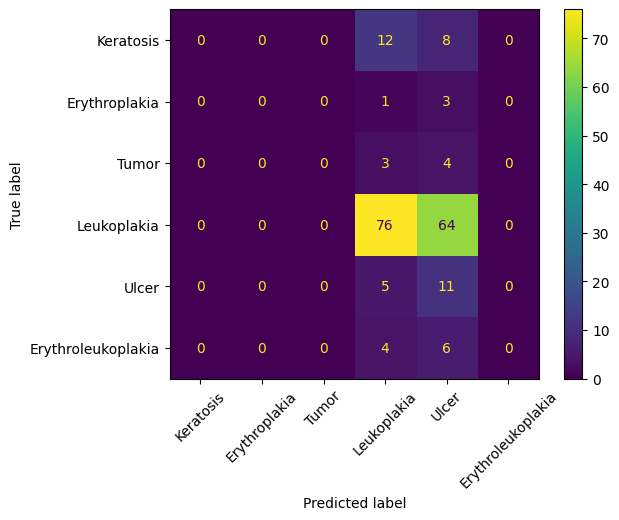

In [25]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_true__, y_pred__, labels=str_labels)
cm = ConfusionMatrixDisplay(cm ,display_labels=str_labels)
cm.plot(xticks_rotation=45)

In [26]:
from sklearn.metrics import classification_report

print(classification_report(y_true__, y_pred__, labels=str_labels))

                    precision    recall  f1-score   support

         Keratosis       0.00      0.00      0.00        20
     Erythroplakia       0.00      0.00      0.00         4
             Tumor       0.00      0.00      0.00         7
       Leukoplakia       0.75      0.54      0.63       140
             Ulcer       0.11      0.69      0.20        16
Erythroleukoplakia       0.00      0.00      0.00        10

          accuracy                           0.44       197
         macro avg       0.14      0.21      0.14       197
      weighted avg       0.54      0.44      0.46       197



/home/kcdh/miniconda3/envs/hanish/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/kcdh/miniconda3/envs/hanish/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/kcdh/miniconda3/envs/hanish/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()